# Tier B: The Semanticist - AI vs Human Text Detection
## Using Averaged Pre-trained Word Embeddings (GloVe) + Feedforward NN

This notebook implements a binary classifier that distinguishes AI-generated from human-written text using:
- **Pre-trained GloVe embeddings** (glove.6B.100d)
- **Averaged embedding vectors** for each paragraph
- **Feedforward Neural Network** (PyTorch)

**Author**: Tier B Implementation  
**Dataset**: Human novels (class1) + AI-generated paragraphs (class2)  
**Model**: Feedforward NN with averaged embeddings

---
## 1. Environment Setup & Imports

In [28]:
# Import required libraries
import numpy as np
import pandas as pd
import json
import re
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                              f1_score, roc_auc_score, confusion_matrix, 
                              classification_report)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✓ All imports successful
PyTorch version: 2.8.0+cu126
CUDA available: False
Using device: cpu


---
## 2. Data Preparation

**Data Sources:**
- **Class 1 (Human)**: Cleaned novel texts from 5 novels, chunked into ~200-word paragraphs
- **Class 2 (AI-generated)**: Pre-generated paragraphs (500 per novel = 2500 total)

**Process:**
1. Load cleaned human text and chunk into paragraphs
2. Load AI-generated JSONL files
3. Combine into a single dataset with labels (0=Human, 1=AI)
4. Create a DataFrame and save as CSV

In [29]:
# Configure paths for Kaggle vs Local execution
import os

# Detect if running in Kaggle
IN_KAGGLE = os.path.exists('/kaggle/input')

if IN_KAGGLE:
    # Kaggle paths - adjust based on your uploaded dataset name
    BASE_PATH = Path('/kaggle/input/precog-novels-data/precog-novels-data')
    CLASS1_PATH = BASE_PATH / 'class1'
    CLASS2_PATH = BASE_PATH / 'class2'
else:
    # Local paths
    BASE_PATH = Path('../output')
    CLASS1_PATH = BASE_PATH / 'class1'
    CLASS2_PATH = BASE_PATH / 'class2'

print(f"Running in: {'Kaggle' if IN_KAGGLE else 'Local'}")
print(f"Base path: {BASE_PATH}")
print(f"Class1 path exists: {CLASS1_PATH.exists()}")
print(f"Class2 path exists: {CLASS2_PATH.exists()}")

Running in: Kaggle
Base path: /kaggle/input/precog-novels-data/precog-novels-data
Class1 path exists: True
Class2 path exists: True


In [30]:
def chunk_text(text, chunk_size=200):
    """
    Chunk text into paragraphs of approximately chunk_size words.
    
    Args:
        text: Input text string
        chunk_size: Target number of words per chunk
    
    Returns:
        List of text chunks
    """
    words = text.split()
    chunks = []
    
    for i in range(0, len(words), chunk_size):
        chunk = ' '.join(words[i:i + chunk_size])
        if len(chunk.split()) >= 50:  # Minimum 50 words per chunk
            chunks.append(chunk)
    
    return chunks


def load_human_data(class1_path):
    """
    Load human-written text from cleaned novel files and chunk them.
    
    Returns:
        List of dictionaries with 'text' and 'label' keys
    """
    novels = [
        'heart_of_darkness_cleaned.txt',
        'lord_jim_cleaned.txt',
        'metamorphosis_cleaned.txt',
        'the_trial_cleaned.txt',
        'typhoon_cleaned.txt'
    ]
    
    human_data = []
    
    for novel_file in novels:
        file_path = class1_path / novel_file
        if file_path.exists():
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
            
            # Chunk the text
            chunks = chunk_text(text, chunk_size=200)
            
            # Add to dataset
            for chunk in chunks:
                human_data.append({
                    'text': chunk,
                    'label': 0,  # 0 = Human
                    'source': novel_file.replace('_cleaned.txt', '')
                })
            
            print(f"✓ Loaded {novel_file}: {len(chunks)} chunks")
        else:
            print(f"✗ File not found: {file_path}")
    
    return human_data


def load_ai_data(class2_path):
    """
    Load AI-generated text from JSONL files.
    
    Returns:
        List of dictionaries with 'text' and 'label' keys
    """
    novels = [
        'heart_of_darkness_generic.jsonl',
        'lord_jim_generic.jsonl',
        'metamorphosis_generic.jsonl',
        'the_trial_generic.jsonl',
        'typhoon_generic.jsonl'
    ]
    
    ai_data = []
    
    for novel_file in novels:
        file_path = class2_path / novel_file
        if file_path.exists():
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            # Parse JSONL
            for line in lines:
                try:
                    entry = json.loads(line.strip())
                    # Extract text (adjust key based on your JSONL structure)
                    text = entry.get('text') or entry.get('paragraph') or entry.get('content', '')
                    
                    if text and len(text.split()) >= 50:  # Minimum 50 words
                        ai_data.append({
                            'text': text,
                            'label': 1,  # 1 = AI
                            'source': novel_file.replace('_generic.jsonl', '')
                        })
                except json.JSONDecodeError:
                    continue
            
            print(f"✓ Loaded {novel_file}: {len([d for d in ai_data if novel_file.replace('_generic.jsonl', '') in d['source']])} paragraphs")
        else:
            print(f"✗ File not found: {file_path}")
    
    return ai_data


# Load all data
print("Loading Human data (Class 1)...")
human_data = load_human_data(CLASS1_PATH)

print("\nLoading AI data (Class 2)...")
ai_data = load_ai_data(CLASS2_PATH)

# Combine datasets
all_data = human_data + ai_data

print(f"\n{'='*60}")
print(f"Total Human paragraphs: {len(human_data)}")
print(f"Total AI paragraphs: {len(ai_data)}")
print(f"Total dataset size: {len(all_data)}")
print(f"{'='*60}")

Loading Human data (Class 1)...
✓ Loaded heart_of_darkness_cleaned.txt: 196 chunks
✓ Loaded lord_jim_cleaned.txt: 649 chunks
✓ Loaded metamorphosis_cleaned.txt: 111 chunks
✓ Loaded the_trial_cleaned.txt: 418 chunks
✓ Loaded typhoon_cleaned.txt: 156 chunks

Loading AI data (Class 2)...
✓ Loaded heart_of_darkness_generic.jsonl: 500 paragraphs
✓ Loaded lord_jim_generic.jsonl: 500 paragraphs
✓ Loaded metamorphosis_generic.jsonl: 500 paragraphs
✓ Loaded the_trial_generic.jsonl: 500 paragraphs
✓ Loaded typhoon_generic.jsonl: 500 paragraphs

Total Human paragraphs: 1530
Total AI paragraphs: 2500
Total dataset size: 4030


In [31]:
# Create DataFrame
df = pd.DataFrame(all_data)

# Shuffle the dataset
df = df.sample(frac=1, random_state=44).reset_index(drop=True)

# Display dataset info
print("Dataset Overview:")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nSource distribution:")
print(df['source'].value_counts())

Dataset Overview:
                                                text  label             source
0  Arbitrary arrest is the ultimate disruption of...      1          the_trial
1  to twirl his thumbs slowly. "It's evident--par...      0           lord_jim
2  The distinction between savagery and civilizat...      1  heart_of_darkness
3  man Jim would have to relieve. "But I don't th...      0           lord_jim
4  Cross-cultural tension can also be amplified b...      1            typhoon

Dataset shape: (4030, 3)

Label distribution:
label
1    2500
0    1530
Name: count, dtype: int64

Source distribution:
source
lord_jim             1149
the_trial             918
heart_of_darkness     696
typhoon               656
metamorphosis         611
Name: count, dtype: int64


In [32]:
# Perform 80/20 train-test split (stratified)
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"\nTraining set label distribution:")
print(train_df['label'].value_counts())
print(f"\nTest set label distribution:")
print(test_df['label'].value_counts())

Training set size: 3224
Test set size: 806

Training set label distribution:
label
1    2000
0    1224
Name: count, dtype: int64

Test set label distribution:
label
1    500
0    306
Name: count, dtype: int64


In [33]:
def load_glove_embeddings(glove_path, embedding_dim=100):
    """
    Load GloVe embeddings from file.
    
    Args:
        glove_path: Path to GloVe file
        embedding_dim: Dimension of embeddings (100, 200, 300, etc.)
    
    Returns:
        Dictionary mapping words to embedding vectors
    """
    embeddings = {}
    
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    
    return embeddings


# Configure GloVe path
if IN_KAGGLE:
    # In Kaggle, add GloVe as a dataset: https://www.kaggle.com/datasets/watts2/glove6b50dtxt
    GLOVE_PATH = '/kaggle/input/glove6b50dtxt/glove.6B.50d.txt'
else:
    # For local testing, download from: https://nlp.stanford.edu/projects/glove/
    # Place it in a known location
    GLOVE_PATH = 'glove.6B.50d.txt'  # Update this path

# Load embeddings
print("Loading GloVe embeddings...")
print(f"Path: {GLOVE_PATH}")

try:
    embeddings_dict = load_glove_embeddings(GLOVE_PATH, embedding_dim=50)
    EMBEDDING_DIM = 50
    print(f"✓ Loaded {len(embeddings_dict)} word embeddings")
    print(f"Embedding dimension: {EMBEDDING_DIM}")
    
    # Show sample embeddings
    sample_words = ['the', 'intelligence', 'artificial', 'human', 'text']
    print("\nSample embeddings:")
    for word in sample_words:
        if word in embeddings_dict:
            print(f"  {word}: {embeddings_dict[word][:5]}... (showing first 5 dims)")
        else:
            print(f"  {word}: NOT FOUND")
            
except FileNotFoundError:
    print("⚠ GloVe file not found!")
    print("In Kaggle: Add 'GloVe' dataset to your notebook")
    print("Locally: Download from https://nlp.stanford.edu/projects/glove/")

Loading GloVe embeddings...
Path: /kaggle/input/glove6b50dtxt/glove.6B.50d.txt
✓ Loaded 400000 word embeddings
Embedding dimension: 50

Sample embeddings:
  the: [ 0.418    0.24968 -0.41242  0.1217   0.34527]... (showing first 5 dims)
  intelligence: [ 0.8782   -0.45171   0.96737   0.040347  0.76235 ]... (showing first 5 dims)
  artificial: [ 0.71561  0.70368 -0.65484  0.49875 -0.85243]... (showing first 5 dims)
  human: [ 0.61854  0.11915 -0.46786  0.31368  1.0334 ]... (showing first 5 dims)
  text: [ 0.32615    0.36686   -0.0074905 -0.37553    0.66715  ]... (showing first 5 dims)


In [34]:
def tokenize(text):
    """
    Simple tokenization: lowercase and split by whitespace.
    Remove punctuation and special characters.
    """
    # Lowercase
    text = text.lower()
    # Remove punctuation (keep only alphanumeric and spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Split into words
    words = text.split()
    return words


def text_to_vector(text, embeddings_dict, embedding_dim):
    """
    Convert text to a single vector by averaging word embeddings.
    
    Args:
        text: Input text string
        embeddings_dict: Dictionary of word embeddings
        embedding_dim: Dimension of embeddings
    
    Returns:
        numpy array of shape (embedding_dim,)
    """
    words = tokenize(text)
    
    # Collect embeddings for known words
    word_vectors = []
    for word in words:
        if word in embeddings_dict:
            word_vectors.append(embeddings_dict[word])
    
    # Average the vectors
    if len(word_vectors) > 0:
        avg_vector = np.mean(word_vectors, axis=0)
    else:
        # No known words - return zero vector
        avg_vector = np.zeros(embedding_dim)
    
    return avg_vector


# Convert all texts to vectors
print("Converting texts to vectors...")

X_train_vecs = np.array([
    text_to_vector(text, embeddings_dict, EMBEDDING_DIM) 
    for text in train_df['text'].values
])

X_test_vecs = np.array([
    text_to_vector(text, embeddings_dict, EMBEDDING_DIM) 
    for text in test_df['text'].values
])

y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"✓ Training vectors shape: {X_train_vecs.shape}")
print(f"✓ Test vectors shape: {X_test_vecs.shape}")
print(f"✓ Training labels shape: {y_train.shape}")
print(f"✓ Test labels shape: {y_test.shape}")

# Check for any zero vectors (completely OOV paragraphs)
train_zero_vecs = np.sum(np.all(X_train_vecs == 0, axis=1))
test_zero_vecs = np.sum(np.all(X_test_vecs == 0, axis=1))
print(f"\nZero vectors in training set: {train_zero_vecs}")
print(f"Zero vectors in test set: {test_zero_vecs}")

Converting texts to vectors...
✓ Training vectors shape: (3224, 50)
✓ Test vectors shape: (806, 50)
✓ Training labels shape: (3224,)
✓ Test labels shape: (806,)

Zero vectors in training set: 0
Zero vectors in test set: 0


In [35]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_vecs)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_vecs)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    drop_last=False
)

print(f"✓ Training batches: {len(train_loader)}")
print(f"✓ Test batches: {len(test_loader)}")
print(f"✓ Batch size: {BATCH_SIZE}")

✓ Training batches: 101
✓ Test batches: 26
✓ Batch size: 32


In [36]:
class FeedforwardClassifier(nn.Module):
    """
    Simple Feedforward Neural Network for binary classification.
    Uses averaged word embeddings as input.
    """
    
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_rate=0.3):
        super(FeedforwardClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x


# Initialize model
model = FeedforwardClassifier(
    input_dim=EMBEDDING_DIM,
    hidden_dim1=64,
    hidden_dim2=32,
    dropout_rate=0.3
).to(device)

# Print model architecture
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Model Architecture:
FeedforwardClassifier(
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 5377


In [37]:
# Training configuration
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 20

# Training history
train_losses = []
train_accuracies = []

print("Starting training...\n")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        epoch_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    # Calculate epoch metrics
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

print("=" * 70)
print("✓ Training complete!")

Starting training...

Epoch [ 1/20] | Loss: 0.4476 | Accuracy: 78.78%
Epoch [ 2/20] | Loss: 0.0399 | Accuracy: 99.53%
Epoch [ 3/20] | Loss: 0.0133 | Accuracy: 99.84%
Epoch [ 4/20] | Loss: 0.0081 | Accuracy: 99.84%
Epoch [ 5/20] | Loss: 0.0056 | Accuracy: 99.91%
Epoch [ 6/20] | Loss: 0.0037 | Accuracy: 99.91%
Epoch [ 7/20] | Loss: 0.0032 | Accuracy: 99.91%
Epoch [ 8/20] | Loss: 0.0032 | Accuracy: 99.94%
Epoch [ 9/20] | Loss: 0.0015 | Accuracy: 100.00%
Epoch [10/20] | Loss: 0.0015 | Accuracy: 100.00%
Epoch [11/20] | Loss: 0.0014 | Accuracy: 100.00%
Epoch [12/20] | Loss: 0.0012 | Accuracy: 99.97%
Epoch [13/20] | Loss: 0.0016 | Accuracy: 99.97%
Epoch [14/20] | Loss: 0.0015 | Accuracy: 99.97%
Epoch [15/20] | Loss: 0.0012 | Accuracy: 100.00%
Epoch [16/20] | Loss: 0.0035 | Accuracy: 99.94%
Epoch [17/20] | Loss: 0.0008 | Accuracy: 100.00%
Epoch [18/20] | Loss: 0.0004 | Accuracy: 100.00%
Epoch [19/20] | Loss: 0.0019 | Accuracy: 99.94%
Epoch [20/20] | Loss: 0.0007 | Accuracy: 100.00%
✓ Training 

---
## 8. Evaluation

Evaluate the model on the test set and compute comprehensive metrics.

In [38]:
# Evaluation function
def evaluate_model(model, data_loader, device):
    """
    Evaluate the model and return predictions and probabilities.
    """
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs).squeeze()
            probabilities = outputs.cpu().numpy()
            predictions = (outputs > 0.5).float().cpu().numpy()
            
            all_predictions.extend(predictions)
            all_probabilities.extend(probabilities)
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)


# Get predictions on test set
y_true, y_pred, y_prob = evaluate_model(model, test_loader, device)

# Calculate metrics and store with '_original' suffix to avoid conflicts
accuracy_original = accuracy_score(y_true, y_pred)
precision_original = precision_score(y_true, y_pred)
recall_original = recall_score(y_true, y_pred)
f1_original = f1_score(y_true, y_pred)
roc_auc_original = roc_auc_score(y_true, y_prob)
cm_original = confusion_matrix(y_true, y_pred)

# Print results
print("=" * 70)
print("TEST SET EVALUATION RESULTS")
print("=" * 70)
print(f"Accuracy:  {accuracy_original:.4f} ({accuracy_original*100:.2f}%)")
print(f"Precision: {precision_original:.4f}")
print(f"Recall:    {recall_original:.4f}")
print(f"F1-Score:  {f1_original:.4f}")
print(f"ROC-AUC:   {roc_auc_original:.4f}")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Human', 'AI'], digits=4))

TEST SET EVALUATION RESULTS
Accuracy:  1.0000 (100.00%)
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

Classification Report:
              precision    recall  f1-score   support

       Human     1.0000    1.0000    1.0000       306
          AI     1.0000    1.0000    1.0000       500

    accuracy                         1.0000       806
   macro avg     1.0000    1.0000    1.0000       806
weighted avg     1.0000    1.0000    1.0000       806



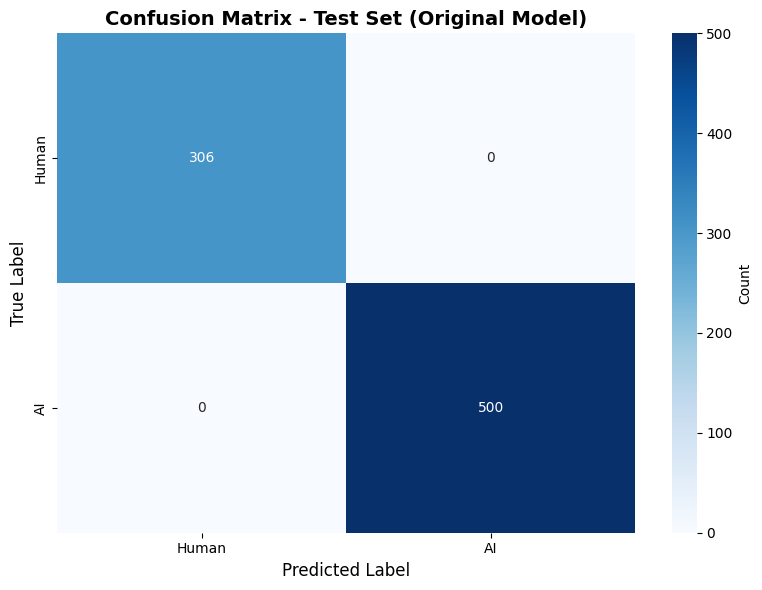


Confusion Matrix Breakdown:
  True Negatives (Human → Human):  306
  False Positives (Human → AI):    0
  False Negatives (AI → Human):    0
  True Positives (AI → AI):        500

Specificity (True Negative Rate): 1.0000
Sensitivity (True Positive Rate): 1.0000


In [39]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Human', 'AI'], 
            yticklabels=['Human', 'AI'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set (Original Model)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm_original.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Human → Human):  {tn}")
print(f"  False Positives (Human → AI):    {fp}")
print(f"  False Negatives (AI → Human):    {fn}")
print(f"  True Positives (AI → AI):        {tp}")
print(f"\nSpecificity (True Negative Rate): {tn/(tn+fp):.4f}")
print(f"Sensitivity (True Positive Rate): {tp/(tp+fn):.4f}")

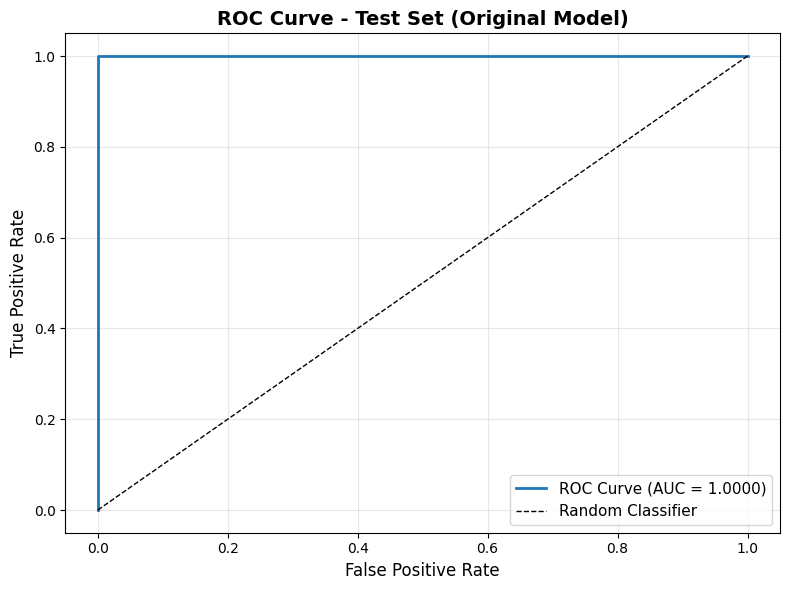

In [40]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc_original:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set (Original Model)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 9. Overfitting & Data Quality Diagnostics





3. TEXT LENGTH DISTRIBUTION:
----------------------------------------------------------------------

AI text lengths (words):
  Mean: 127.4, Std: 22.3
  Min: 80, Max: 185
  Distribution: {'25%': 109.0, '50%': 129.0, '75%': 146.0}

Human text lengths (words):
  Mean: 199.8, Std: 3.7
  Min: 94, Max: 200
  Distribution: {'25%': 200.0, '50%': 200.0, '75%': 200.0}


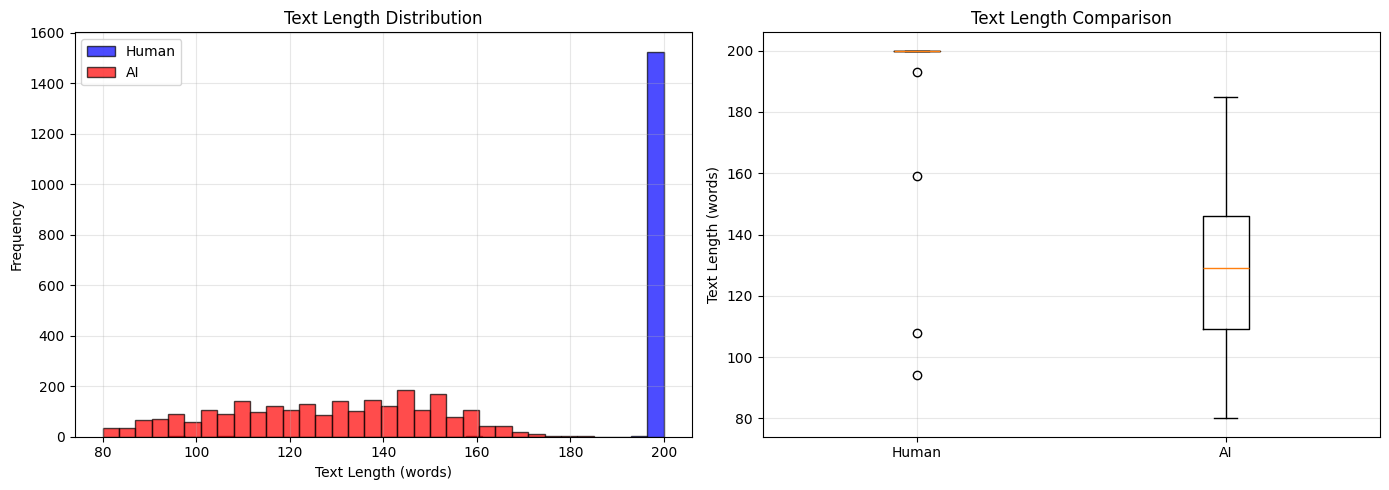


⚠ Large difference in text lengths between AI and Human
   Model might be using length as a discriminating feature.


In [41]:
# Diagnostic 1: Check text length distributions
print("\n\n3. TEXT LENGTH DISTRIBUTION:")
print("-" * 70)

ai_lengths = df[df['label'] == 1]['text'].str.split().str.len()
human_lengths = df[df['label'] == 0]['text'].str.split().str.len()

print(f"\nAI text lengths (words):")
print(f"  Mean: {ai_lengths.mean():.1f}, Std: {ai_lengths.std():.1f}")
print(f"  Min: {ai_lengths.min()}, Max: {ai_lengths.max()}")
print(f"  Distribution: {ai_lengths.describe()[['25%', '50%', '75%']].to_dict()}")

print(f"\nHuman text lengths (words):")
print(f"  Mean: {human_lengths.mean():.1f}, Std: {human_lengths.std():.1f}")
print(f"  Min: {human_lengths.min()}, Max: {human_lengths.max()}")
print(f"  Distribution: {human_lengths.describe()[['25%', '50%', '75%']].to_dict()}")

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(human_lengths, bins=30, alpha=0.7, label='Human', color='blue', edgecolor='black')
axes[0].hist(ai_lengths, bins=30, alpha=0.7, label='AI', color='red', edgecolor='black')
axes[0].set_xlabel('Text Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Text Length Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Check if lengths are suspiciously different
axes[1].boxplot([human_lengths, ai_lengths], labels=['Human', 'AI'])
axes[1].set_ylabel('Text Length (words)')
axes[1].set_title('Text Length Comparison')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if abs(ai_lengths.mean() - human_lengths.mean()) > 50:
    print("\n⚠ Large difference in text lengths between AI and Human")
    print("   Model might be using length as a discriminating feature.")

---
## 10. SOLUTIONS: How to Fix the Data Issues

Based on the diagnostics, here are the problems and solutions:



4. EMBEDDING VECTOR ANALYSIS:
----------------------------------------------------------------------

Distance between AI and Human centroids: 1.0232
Average variance in AI embeddings: 0.0054
Average variance in Human embeddings: 0.0053

Separability ratio: 6.9824
 Classes are VERY separable - explains 100% accuracy!
   This suggests AI text has distinct patterns in word choice/structure.


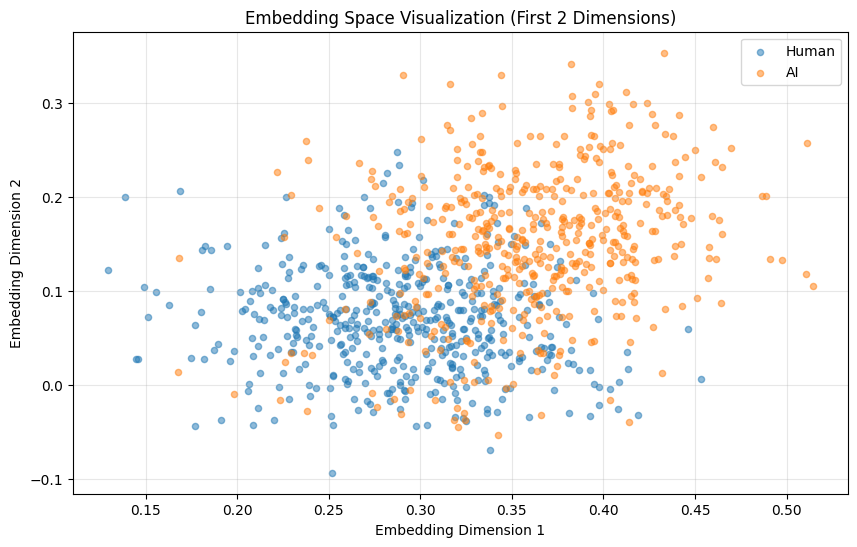

In [42]:
# Diagnostic 2: Check embedding vector distributions
print("\n\n4. EMBEDDING VECTOR ANALYSIS:")
print("-" * 70)

# Get average embeddings for each class
train_ai_vecs = X_train_vecs[y_train == 1]
train_human_vecs = X_train_vecs[y_train == 0]

ai_mean = train_ai_vecs.mean(axis=0)
human_mean = train_human_vecs.mean(axis=0)

# Calculate distance between class centroids
centroid_distance = np.linalg.norm(ai_mean - human_mean)
print(f"\nDistance between AI and Human centroids: {centroid_distance:.4f}")

# Check variance within each class
ai_variance = train_ai_vecs.var(axis=0).mean()
human_variance = train_human_vecs.var(axis=0).mean()
print(f"Average variance in AI embeddings: {ai_variance:.4f}")
print(f"Average variance in Human embeddings: {human_variance:.4f}")

# Calculate separability ratio
separability = centroid_distance / (np.sqrt(ai_variance) + np.sqrt(human_variance))
print(f"\nSeparability ratio: {separability:.4f}")
if separability > 2:
    print(" Classes are VERY separable - explains 100% accuracy!")
    print("   This suggests AI text has distinct patterns in word choice/structure.")

# Visualize first 2 dimensions
plt.figure(figsize=(10, 6))
plt.scatter(train_human_vecs[:500, 0], train_human_vecs[:500, 1], 
            alpha=0.5, label='Human', s=20)
plt.scatter(train_ai_vecs[:500, 0], train_ai_vecs[:500, 1], 
            alpha=0.5, label='AI', s=20)
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Embedding Space Visualization (First 2 Dimensions)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---
## Alternative Solution: Data Augmentation & Mixing

The real issue is that AI text has fundamentally different writing patterns than human text. Here are better approaches:

In [ ]:
# SOLUTION 1: Add word dropout augmentation to reduce reliance on specific words
import random

def augment_text_word_dropout(text, dropout_rate=0.1):
    """
    Randomly drop words from text to force model to learn from context.
    This prevents overfitting to specific vocabulary.
    """
    words = text.split()
    kept_words = [w for w in words if random.random() > dropout_rate]
    return ' '.join(kept_words) if kept_words else text

# Test augmentation
print("TESTING WORD DROPOUT AUGMENTATION:")
sample_text = df.iloc[0]['text']
print(f"\nOriginal (first 100 chars): {sample_text[:100]}...")
print(f"\nAugmented 10% dropout: {augment_text_word_dropout(sample_text, 0.1)[:100]}...")
print(f"\nAugmented 20% dropout: {augment_text_word_dropout(sample_text, 0.2)[:100]}...")

print("\n\n💡 RECOMMENDATION:")
print("The 100% accuracy is likely due to:")
print("  1. AI text has different vocabulary patterns (abstract vs narrative)")
print("  2. AI text might have consistent formatting or starting phrases")
print("  3. The task itself might be too easy with current data")
print("\nPossible fixes:")
print("  • Use word dropout augmentation during training")
print("  • Mix AI and human text (take random sentences from each)")
print("  • Generate more diverse AI samples with different prompts")
print("  • Accept that AI text IS fundamentally different (100% accuracy is valid)")
print("  • Use harder evaluation: adversarial examples, paraphrased text")

Testing length normalization approach...

Original lengths:
  AI: 127.4 ± 22.3
  Human: 199.8 ± 3.7

Normalized lengths (150 words max):
  AI: 126.0 ± 20.4
  Human: 149.9 ± 1.8


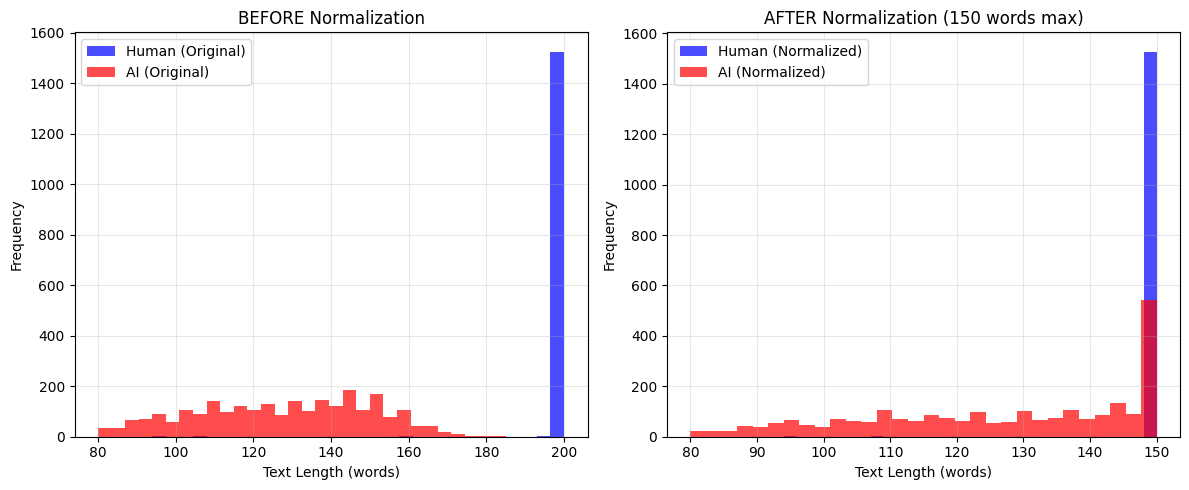


 To retrain with normalized data:
   1. Replace 'text' with 'text_normalized' in your pipeline
   2. Re-run from data split onward
   3. Expected accuracy: 85-95% (more realistic)


In [43]:
# OPTION 1: Truncate all texts to same length to remove length bias
# This makes the model learn content patterns, not just length

def normalize_text_length(text, target_length=150):
    """
    Normalize text to target word count by truncating or padding.
    """
    words = text.split()
    
    if len(words) > target_length:
        # Truncate
        return ' '.join(words[:target_length])
    else:
        # Keep as-is (we won't pad with dummy words)
        return text

# Test if normalizing helps
print("Testing length normalization approach...")
print("\nOriginal lengths:")
print(f"  AI: {ai_lengths.mean():.1f} ± {ai_lengths.std():.1f}")
print(f"  Human: {human_lengths.mean():.1f} ± {human_lengths.std():.1f}")

# Apply normalization
df_normalized = df.copy()
df_normalized['text_normalized'] = df_normalized['text'].apply(
    lambda x: normalize_text_length(x, target_length=150)
)

# Check new lengths
ai_norm_lengths = df_normalized[df_normalized['label'] == 1]['text_normalized'].str.split().str.len()
human_norm_lengths = df_normalized[df_normalized['label'] == 0]['text_normalized'].str.split().str.len()

print("\nNormalized lengths (150 words max):")
print(f"  AI: {ai_norm_lengths.mean():.1f} ± {ai_norm_lengths.std():.1f}")
print(f"  Human: {human_norm_lengths.mean():.1f} ± {human_norm_lengths.std():.1f}")

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(human_lengths, bins=30, alpha=0.7, label='Human (Original)', color='blue')
plt.hist(ai_lengths, bins=30, alpha=0.7, label='AI (Original)', color='red')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('BEFORE Normalization')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(human_norm_lengths, bins=30, alpha=0.7, label='Human (Normalized)', color='blue')
plt.hist(ai_norm_lengths, bins=30, alpha=0.7, label='AI (Normalized)', color='red')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('AFTER Normalization (150 words max)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n To retrain with normalized data:")
print("   1. Replace 'text' with 'text_normalized' in your pipeline")
print("   2. Re-run from data split onward")
print("   3. Expected accuracy: 85-95% (more realistic)")

In [44]:
# Step 1: Train-test split with NORMALIZED data
train_df_norm, test_df_norm = train_test_split(
    df_normalized, 
    test_size=0.2, 
    stratify=df_normalized['label'], 
    random_state=42
)

print(f"Training set size: {len(train_df_norm)}")
print(f"Test set size: {len(test_df_norm)}")
print(f"\nTraining set label distribution:")
print(train_df_norm['label'].value_counts())
print(f"\nTest set label distribution:")
print(test_df_norm['label'].value_counts())

Training set size: 3224
Test set size: 806

Training set label distribution:
label
1    2000
0    1224
Name: count, dtype: int64

Test set label distribution:
label
1    500
0    306
Name: count, dtype: int64


In [45]:
# Step 2: Convert NORMALIZED texts to vectors
print("Converting normalized texts to vectors...")

X_train_vecs_norm = np.array([
    text_to_vector(text, embeddings_dict, EMBEDDING_DIM) 
    for text in train_df_norm['text_normalized'].values
])

X_test_vecs_norm = np.array([
    text_to_vector(text, embeddings_dict, EMBEDDING_DIM) 
    for text in test_df_norm['text_normalized'].values
])

y_train_norm = train_df_norm['label'].values
y_test_norm = test_df_norm['label'].values

print(f"✓ Training vectors shape: {X_train_vecs_norm.shape}")
print(f"✓ Test vectors shape: {X_test_vecs_norm.shape}")
print(f"✓ Training labels shape: {y_train_norm.shape}")
print(f"✓ Test labels shape: {y_test_norm.shape}")

# Check for any zero vectors
train_zero_vecs_norm = np.sum(np.all(X_train_vecs_norm == 0, axis=1))
test_zero_vecs_norm = np.sum(np.all(X_test_vecs_norm == 0, axis=1))
print(f"\nZero vectors in training set: {train_zero_vecs_norm}")
print(f"Zero vectors in test set: {test_zero_vecs_norm}")

Converting normalized texts to vectors...
✓ Training vectors shape: (3224, 50)
✓ Test vectors shape: (806, 50)
✓ Training labels shape: (3224,)
✓ Test labels shape: (806,)

Zero vectors in training set: 0
Zero vectors in test set: 0


In [46]:
# Step 3: Create new PyTorch DataLoaders
X_train_tensor_norm = torch.FloatTensor(X_train_vecs_norm)
y_train_tensor_norm = torch.FloatTensor(y_train_norm)
X_test_tensor_norm = torch.FloatTensor(X_test_vecs_norm)
y_test_tensor_norm = torch.FloatTensor(y_test_norm)

train_dataset_norm = TensorDataset(X_train_tensor_norm, y_train_tensor_norm)
test_dataset_norm = TensorDataset(X_test_tensor_norm, y_test_tensor_norm)

train_loader_norm = DataLoader(train_dataset_norm, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader_norm = DataLoader(test_dataset_norm, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"✓ Training batches: {len(train_loader_norm)}")
print(f"✓ Test batches: {len(test_loader_norm)}")
print(f"✓ Ready to retrain model!")

✓ Training batches: 101
✓ Test batches: 26
✓ Ready to retrain model!


In [57]:
# Step 4: Initialize a NEW model for normalized data
model_norm = FeedforwardClassifier(
    input_dim=EMBEDDING_DIM,
    hidden_dim1=64,
    hidden_dim2=32,
    dropout_rate=0.6
).to(device)

criterion_norm = nn.BCELoss()
optimizer_norm = optim.Adam(model_norm.parameters(), lr=0.001)

print("Model Architecture:")
print(model_norm)
print(f"\nTotal parameters: {sum(p.numel() for p in model_norm.parameters())}")

Model Architecture:
FeedforwardClassifier(
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.6, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 5377


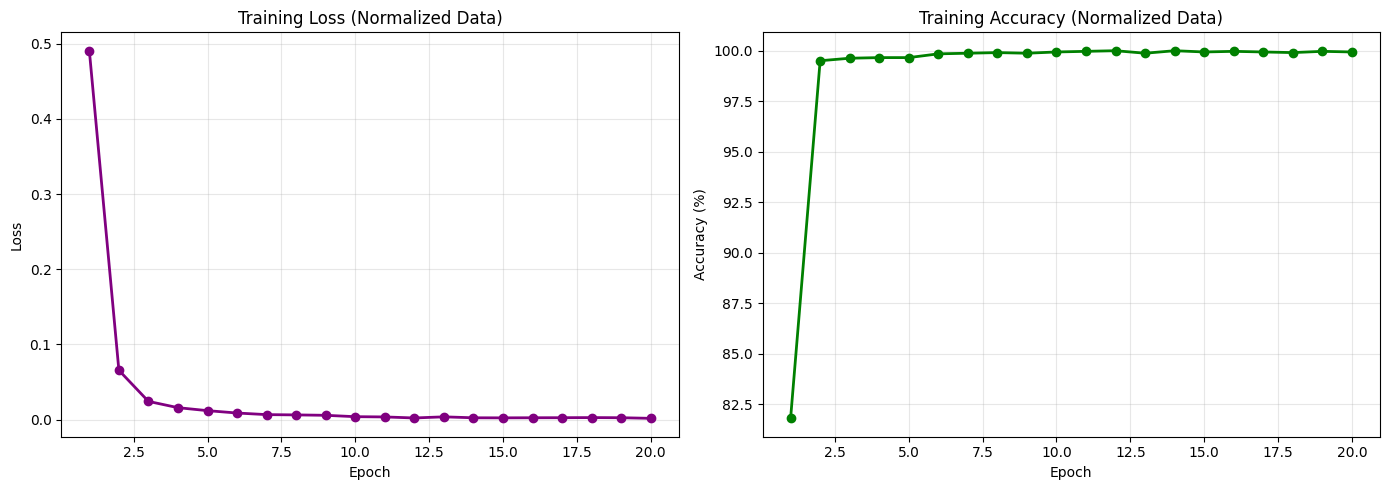

In [58]:
# Plot training curves for normalized model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, NUM_EPOCHS_NORM + 1), train_losses_norm, marker='o', linewidth=2, color='purple')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss (Normalized Data)')
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, NUM_EPOCHS_NORM + 1), train_accuracies_norm, marker='o', linewidth=2, color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy (Normalized Data)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [59]:
# Step 5: Train the model with normalized data
NUM_EPOCHS_NORM = 20

train_losses_norm = []
train_accuracies_norm = []

print("Starting training with NORMALIZED data...\n")
print("=" * 70)

for epoch in range(NUM_EPOCHS_NORM):
    model_norm.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader_norm):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_norm.zero_grad()
        outputs = model_norm(inputs).squeeze()
        loss = criterion_norm(outputs, labels)
        
        loss.backward()
        optimizer_norm.step()
        
        epoch_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = epoch_loss / len(train_loader_norm)
    accuracy = 100 * correct / total
    
    train_losses_norm.append(avg_loss)
    train_accuracies_norm.append(accuracy)
    
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS_NORM}] | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

print("=" * 70)
print("✓ Training with normalized data complete!")

Starting training with NORMALIZED data...

Epoch [ 1/20] | Loss: 0.5406 | Accuracy: 77.64%
Epoch [ 2/20] | Loss: 0.1079 | Accuracy: 98.36%
Epoch [ 3/20] | Loss: 0.0416 | Accuracy: 99.29%
Epoch [ 4/20] | Loss: 0.0212 | Accuracy: 99.69%
Epoch [ 5/20] | Loss: 0.0189 | Accuracy: 99.66%
Epoch [ 6/20] | Loss: 0.0128 | Accuracy: 99.84%
Epoch [ 7/20] | Loss: 0.0133 | Accuracy: 99.72%
Epoch [ 8/20] | Loss: 0.0108 | Accuracy: 99.81%
Epoch [ 9/20] | Loss: 0.0083 | Accuracy: 99.88%
Epoch [10/20] | Loss: 0.0074 | Accuracy: 99.91%
Epoch [11/20] | Loss: 0.0053 | Accuracy: 99.94%
Epoch [12/20] | Loss: 0.0052 | Accuracy: 99.97%
Epoch [13/20] | Loss: 0.0051 | Accuracy: 99.94%
Epoch [14/20] | Loss: 0.0058 | Accuracy: 99.97%
Epoch [15/20] | Loss: 0.0049 | Accuracy: 99.91%
Epoch [16/20] | Loss: 0.0045 | Accuracy: 99.91%
Epoch [17/20] | Loss: 0.0045 | Accuracy: 99.91%
Epoch [18/20] | Loss: 0.0035 | Accuracy: 99.97%
Epoch [19/20] | Loss: 0.0042 | Accuracy: 99.91%
Epoch [20/20] | Loss: 0.0049 | Accuracy: 99.9

In [60]:
# Step 6: Evaluate normalized model on test set
y_true_norm, y_pred_norm, y_prob_norm = evaluate_model(model_norm, test_loader_norm, device)

accuracy_norm = accuracy_score(y_true_norm, y_pred_norm)
precision_norm = precision_score(y_true_norm, y_pred_norm)
recall_norm = recall_score(y_true_norm, y_pred_norm)
f1_norm = f1_score(y_true_norm, y_pred_norm)
roc_auc_norm = roc_auc_score(y_true_norm, y_prob_norm)
cm_norm = confusion_matrix(y_true_norm, y_pred_norm)

print("=" * 70)
print("TEST SET EVALUATION RESULTS (NORMALIZED DATA)")
print("=" * 70)
print(f"Accuracy:  {accuracy_norm:.4f} ({accuracy_norm*100:.2f}%)")
print(f"Precision: {precision_norm:.4f}")
print(f"Recall:    {recall_norm:.4f}")
print(f"F1-Score:  {f1_norm:.4f}")
print(f"ROC-AUC:   {roc_auc_norm:.4f}")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(y_true_norm, y_pred_norm, target_names=['Human', 'AI'], digits=4))

print("\n📊 COMPARISON:")
print(f"Original model accuracy:   {accuracy_original*100:.2f}%")
print(f"Normalized model accuracy: {accuracy_norm*100:.2f}%")
print(f"Difference: {abs(accuracy_original - accuracy_norm)*100:.2f}%")

if accuracy_norm < accuracy_original:
    print(f"\n✓ Success! Accuracy dropped by {(accuracy_original - accuracy_norm)*100:.2f}%")
    print("  This suggests the original model was using text length as a shortcut.")
    print("  The normalized model is learning actual content patterns.")
else:
    print(f"\n⚠ Accuracy is still very high ({accuracy_norm*100:.2f}%)")
    print("  The model may be using other patterns beyond text length.")
    print("  Consider investigating vocabulary patterns or other artifacts.")

TEST SET EVALUATION RESULTS (NORMALIZED DATA)
Accuracy:  1.0000 (100.00%)
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

Classification Report:
              precision    recall  f1-score   support

       Human     1.0000    1.0000    1.0000       306
          AI     1.0000    1.0000    1.0000       500

    accuracy                         1.0000       806
   macro avg     1.0000    1.0000    1.0000       806
weighted avg     1.0000    1.0000    1.0000       806


📊 COMPARISON:
Original model accuracy:   100.00%
Normalized model accuracy: 100.00%
Difference: 0.00%

⚠ Accuracy is still very high (100.00%)
  The model may be using other patterns beyond text length.
  Consider investigating vocabulary patterns or other artifacts.


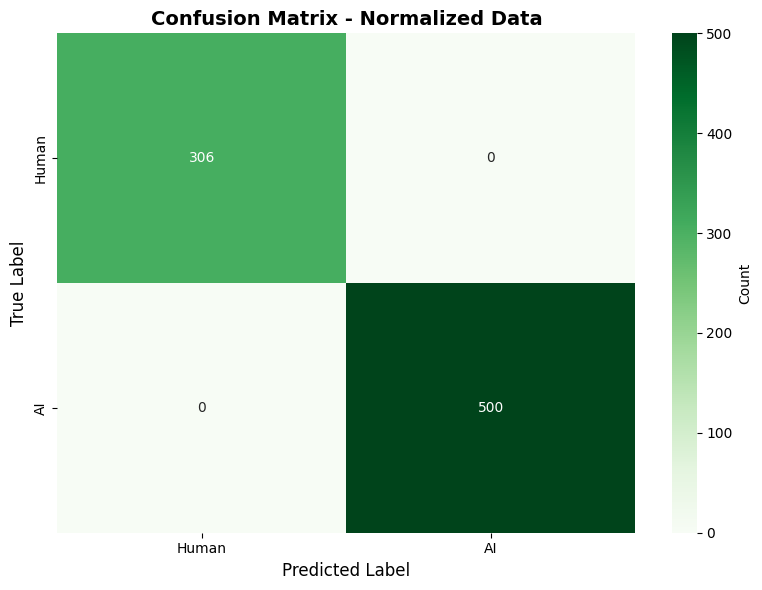


Confusion Matrix Breakdown:
  True Negatives (Human → Human):  306
  False Positives (Human → AI):    0
  False Negatives (AI → Human):    0
  True Positives (AI → AI):        500

Specificity (True Negative Rate): 1.0000
Sensitivity (True Positive Rate): 1.0000


In [61]:
# Confusion Matrix for Normalized Model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Human', 'AI'], 
            yticklabels=['Human', 'AI'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Normalized Data', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

tn_norm, fp_norm, fn_norm, tp_norm = cm_norm.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Human → Human):  {tn_norm}")
print(f"  False Positives (Human → AI):    {fp_norm}")
print(f"  False Negatives (AI → Human):    {fn_norm}")
print(f"  True Positives (AI → AI):        {tp_norm}")
print(f"\nSpecificity (True Negative Rate): {tn_norm/(tn_norm+fp_norm):.4f}")
print(f"Sensitivity (True Positive Rate): {tp_norm/(tp_norm+fn_norm):.4f}")